In [321]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [322]:
TRAY_BOX_PIX = (250, 20, 630, 300)  # xmin, ymin, xmax, ymax

BREAD_HSV_LOWER_BOUND = (10, 30, 100)
BREAD_HSV_UPPER_BOUND = (40, 255, 255)

TRAY_HSV_LOWER_BOUND = (85, 50, 20)
TRAY_HSV_UPPER_BOUND = (100, 255, 255)

In [323]:
first_img_path = "/home/parth/snaak/data/SCH_images_032335/ham_assembly/image_20250323-162125.png"
second_img_path = "/home/parth/snaak/data/SCH_images_032335/ham_assembly/image_20250323-162127.png"

first_img = cv2.imread(first_img_path)
second_img = cv2.imread(second_img_path)

# resize the images to 840x480
first_img = cv2.resize(first_img, (840, 480))
second_img = cv2.resize(second_img, (840, 480))

In [324]:
# Crop the tray box from the bread image
first_crop = first_img[TRAY_BOX_PIX[1]:TRAY_BOX_PIX[3], TRAY_BOX_PIX[0]:TRAY_BOX_PIX[2]]

# Crop the tray box from the first ham image
second_crop = second_img[TRAY_BOX_PIX[1]:TRAY_BOX_PIX[3], TRAY_BOX_PIX[0]:TRAY_BOX_PIX[2]]

In [325]:
# plt.imshow(cv2.cvtColor(first_crop, cv2.COLOR_BGR2RGB))
# plt.axis('off')
# plt.show()

In [326]:
# plt.imshow(cv2.cvtColor(second_crop, cv2.COLOR_BGR2RGB))
# plt.axis('off')
# plt.show()

In [327]:
# Segment bread from the second image using bread HSV values
# Convert the image to HSV color space
second_hsv = cv2.cvtColor(second_crop, cv2.COLOR_BGR2HSV)
bread_hsv_lower_bound = np.array(BREAD_HSV_LOWER_BOUND, dtype=np.uint8)
bread_hsv_upper_bound = np.array(BREAD_HSV_UPPER_BOUND, dtype=np.uint8)
bread_mask = cv2.inRange(second_hsv, bread_hsv_lower_bound, bread_hsv_upper_bound)

# Invert the bread mask and show it
bread_mask_inv = cv2.bitwise_not(bread_mask)
# plt.imshow(bread_mask_inv, cmap='gray')
# plt.axis('off')
# plt.show()

In [328]:
# Segment tray from the second image using tray HSV values
# Convert the image to HSV color space
second_hsv = cv2.cvtColor(second_crop, cv2.COLOR_BGR2HSV)
tray_hsv_lower_bound = np.array(TRAY_HSV_LOWER_BOUND, dtype=np.uint8)
tray_hsv_upper_bound = np.array(TRAY_HSV_UPPER_BOUND, dtype=np.uint8)
tray_mask = cv2.inRange(second_hsv, tray_hsv_lower_bound, tray_hsv_upper_bound)
# Invert the tray mask and show it
tray_mask_inv = cv2.bitwise_not(tray_mask)
# plt.imshow(tray_mask_inv, cmap='gray')
# plt.axis('off')
# plt.show()

In [329]:
# Calculate the difference between the two images
diff = cv2.absdiff(first_crop, second_crop)
gray_diff = cv2.cvtColor(diff, cv2.COLOR_BGR2GRAY)


# And operate the difference image with bread mask and tray mask
gray_diff = cv2.bitwise_and(gray_diff, gray_diff, mask=bread_mask_inv)
gray_diff = cv2.bitwise_and(gray_diff, gray_diff, mask=tray_mask_inv)


# Remove noise from the difference image
gray_diff = cv2.GaussianBlur(gray_diff, (7, 7), 0)

# plt.imshow(gray_diff, cmap='gray')
# plt.axis('off')
# plt.show()

In [330]:
# Apply hough tranform to find circles in the image
circles = cv2.HoughCircles(gray_diff, cv2.HOUGH_GRADIENT, dp=1, minDist=50,
                           param1=50, param2=15, minRadius=45, maxRadius=60)

# plot_img = second_crop.copy()
# if circles is not None:
#     circles = np.uint16(np.around(circles))
#     for i in circles[0, :]:
#         # Draw the outer circle
#         cv2.circle(plot_img, (i[0], i[1]), i[2], (0, 255, 0), 2)
#         # Print the radius
#         print("Radius: ", i[2])
#         # Draw the center of the circle
#         cv2.circle(plot_img, (i[0], i[1]), 2, (0, 0, 255), 3)

# plt.imshow(plot_img)
# plt.axis('off')
# plt.show()

Circle center:  (np.uint16(132), np.uint16(214)) Score:  366181
Circle center:  (np.uint16(58), np.uint16(122)) Score:  3217


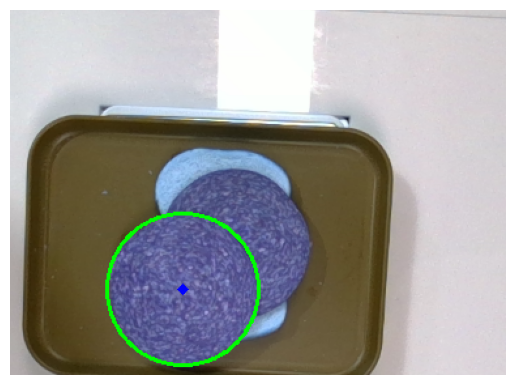

Best circle center:  (np.uint16(132), np.uint16(214)) Score:  366181


In [331]:
circles = np.uint16(np.around(circles))
circle_scores = []
for i in circles[0, :]:
    circle_filter = np.zeros_like(gray_diff)
    cv2.circle(circle_filter, (i[0], i[1]), i[2], (255, 255, 255), -1)
    masked_img = cv2.bitwise_and(gray_diff, circle_filter)
    score = np.sum(masked_img)
    circle_scores.append(score)

    # Print circle center and score
    print("Circle center: ", (i[0], i[1]), "Score: ", score)

# Find the index of the circle with the maximum score
max_index = np.argmax(circle_scores)
# Get the circle with the maximum score
best_circle = circles[0, max_index]
# Draw the best circle on the image
best_circle_img = second_crop.copy()
cv2.circle(best_circle_img, (best_circle[0], best_circle[1]), best_circle[2], (0, 255, 0), 2)
# Draw the center of the best circle
cv2.circle(best_circle_img, (best_circle[0], best_circle[1]), 2, (0, 0, 255), 3)
plt.imshow(best_circle_img)
plt.axis('off')
plt.show()
# Print the best circle center and score
print("Best circle center: ", (best_circle[0], best_circle[1]), "Score: ", circle_scores[max_index])